# Script to
combine annotated genome files in RDF saved in .hdt format with phenotype information from a wikibase instance using the SPARQL endpoint http://sparql.systemsbiology.nl/.

## input
The input is a SPARQL query, [getGenotype.txt](https://gitlab.com/wurssb/StudentProjects/phenotypePredML/-/blob/master/SPARQL_queries/geno_queries/getGenotype.txt), and a folder with .hdt files. The HDTQuery.jar.1 program is used to query all .hdt files in this folder, retrieving the protein domain counts and GCA numbers in a .csv file.

For each phenotype evaluated, a separate SPARQL query is used to retrieve the GCA number and phenotype, located in the folder [pheno_queries](https://gitlab.com/wurssb/StudentProjects/phenotypePredML/-/tree/master/SPARQL_queries/pheno_queries). 

Each phenotype dataset is intersected with the genomic (i.e. the protein domain counts) data using the shared GCA numbers as unique identifiers, retaining the species with both genomic and phenotypic information. These are subsequently stored as Pandas DataFrames in .csv format, with on each row the GCA number as index label, the protein domain counts as columns, as well as a column with the particular phenotype.

## output
 - a .csv file with GCA numbers and protein domain counts

    and for each phenotype:
 - a .csv file with the GCA number, organism name and phenotype
 - a .csv file with the intersection via the GCA numbers of the protein domains and phenotypes. This is used as input for the [final_ml_pipeline](https://gitlab.com/wurssb/StudentProjects/phenotypePredML/-/blob/master/code/final_ml_pipeline.ipynb).

## settings to set before running
The original data was queried on the nvme2 server. 
It has been tested on the server. It might not work on a laptop, due to the pivotting that needs to happen when intersecting the dataframes.

At Start spark session, please: 
 - set the correct python version.
 - set the correct spark settings. comment 'local' if working via server and v.v. 


## todo's
 - store as pickle
 - extend to make it easy to query different things (genes, domains, domain count etc.)
 

## import libraries

In [1]:
import os
import pandas as pd

import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *


# for parallel execution with spark
from sklearn.utils import parallel_backend
from joblibspark import register_spark

from time import time
import subprocess
from SPARQLWrapper import SPARQLWrapper, JSON
# sc.stop()

## Start spark session

In [3]:
# Set python version 
os.environ["PYSPARK_PYTHON"] = "/home/kewin/anaconda3/bin/python3.7"


# Start spark session

# Via server
# conf = pyspark.SparkConf()
# conf.setMaster('spark://nvme2:7077')
# conf.set("spark.cores.max", "20")
# conf.set("spark.executors.cores","5")
# conf.set('spark.executor.memory', '5g')
# # Set max value to 15000 because it is too big
# conf.set("spark.sql.pivotMaxValues",u"15000")
# sc = pyspark.SparkContext(conf=conf)

# Local
sc = pyspark.SparkContext('local[*]')

spark = SparkSession(sc)
register_spark() # register spark backend, for parallel_backend 

## Genotype functions

In [4]:
def query_genotype(input_folder, outname, geno_query, HDTQuery_path='../'):
    """Extract genotype information using a SPARQL query

    input_folder: str name of input folder containing .hdt files
    geno_query: str name of SPARQL query text file

    return: csv file with selected SPARQL variables as columns
    """
    # return output if it already exists
    if os.path.exists(outname):
        return outname
    # if not, build the command and send it to the shell
    print(f"Doing query {geno_query}")
    t0 = time()
    cmd = f"java -jar {HDTQuery_path}HDTQuery.jar -i {input_folder} -f csv -o {outname} -r -query {geno_query}"
    subprocess.check_call(cmd, shell=True)
    print(f"Done ({(time() - t0):.1f}) sec")
    return outname

## Phenotype functions

In [5]:
def query_phenotype(pheno_query, endpoint, limit=0):
    """Extract phenotype information using a SPARQL query from the input endpoint

    pheno_query: str name of SPARQL query text file (from same dir)
    endpoint: str name of endpoint where the query is executed
    limit: int query limit

    return: list of lists of [[Species, domain, domain count], -->]
    """
    with open(pheno_query, 'r') as f:
        query = f.read()
    if limit != 0:
        query += " limit " + str(limit)

    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)  # csv doesn't work
    results = sparql.query().convert()
    return results


def json_to_csv(infile, outfile):
    """Convert a json from a SPARQL query to csv format

    infile: str name of JSON file
    outfile: str name of output csv
    """
    data_dict = {}
    var_list = infile["head"]["vars"]
    for var in var_list:
        # print(var)
        data_dict[var] = list(map(lambda res: res[var]["value"],
                                  infile["results"]["bindings"]))
    df = pd.DataFrame.from_dict(data_dict)
    df.set_index(df.columns[0], inplace=True)
    df.to_csv(outfile)    
    return outfile


def retrieve_pheno_csv(input_query, output_folder, endpoint):
    infile_name = input_query.split("/")[-1][3:-4]
    output_file = output_folder + infile_name + ".csv"

    if os.path.exists(output_file):
        return output_file
    else:
        pheno_json = query_phenotype(input_query, endpoint, limit=0)
        pheno_csv = json_to_csv(pheno_json, output_file)
    return pheno_csv

## Intersection - RDD functions

In [6]:
def preprocess_rdd(genotype_rdd, phenotype_rdd):
    """Clean & collect genotype_rdd based on intersection with phenotype_rdd
    
    genotype_rdd: str, pyspark RDD with SPARQL variables
    phenotype_rdd: str, pyspark RDD with SPARQL variables 
    
    genome_pheno_rdd: Cleaned genotype_rdd filtered by keeping only 
    the GCA entries shared with phenotype_rdd
    """
    t0 = time()

    # Split each row
    genotype_rdd = genotype_rdd.flatMap(lambda line: line.split('\n'))
    phenotype_rdd = phenotype_rdd.flatMap(lambda line: line.split('\n'))

    # Parse GCA number
    genotype_rdd = genotype_rdd.map(lambda line: ((line.split(',')[0])[21:34], [line.split(',')[1], line.split(',')[2]]))
    
    # Group by GCA
    grouped_geno_rdd = genotype_rdd.groupByKey()

    # Parse pheno rdd
    phenotype_rdd = phenotype_rdd.map(lambda line: (line.split(',')[0], line.split(',')[1], line.split(',')[2]))

    # Join geno & phenotype data by filtering the geno by the pheno data
    genome_pheno_rdd = grouped_geno_rdd.join(phenotype_rdd)

    print(f'Intersection RDD Done ({(time() - t0):.1f} sec)')
    return genome_pheno_rdd


def convert_rdd_to_df(genome_pheno_rdd):
    """Todo: add docstrings
    """
    t0 = time()

    # Collect RDD into list (can take a lot of time)
    genome_pheno_list = genome_pheno_rdd.collect()
    print(genome_pheno_list[:100])
    
    running_time = time() - t0
    print(f'RDD collected ({running_time:.1f} sec)')
    
    if len(genome_pheno_list) == 0:
        print("Error: len collected RDD", len(genome_pheno_list))
    else:
        t0 = time()
        
        # Convert list into dict
        useful_data_dict = {}
        for sample, value in genome_pheno_list:
            useful_data_dict[sample] = {}
            for domain, count in value[0]:
                useful_data_dict[sample][domain] = int(count)
            useful_data_dict[sample]["phenotype"] = value[1]

        # Convert dict into pandas df
        genotype_pheno_df = pd.DataFrame(useful_data_dict).T.fillna(0)
        running_time = time() - t0
        print(f'Conversion to pandas DF done ({running_time:.1f} sec)')        
        
        return genotype_pheno_df

## Main

In [ ]:
geno_query_PATH = "../SPARQL_queries/geno_queries/"
pheno_query_PATH = "../SPARQL_queries/pheno_queries/"
data_PATH = "../data/"
HDT_PATH = "../data/Bacteria/"
endpoint = "http://sparql.systemsbiology.nl/proxy/wdqs/bigdata/namespace/wdq/sparql"


geno_query = "getDomainCounts.txt"
geno_name = "all_domain_counts.csv"
outfile_prefix = "pheno_geno_"



with parallel_backend(backend='spark', n_jobs=-1):
    t0_total = time()
    
    
    #   Geno query
    if os.path.exists(data_PATH + geno_name):
        print(f"{data_PATH + geno_name} already exists")
        geno_rdd = sc.textFile(data_PATH + geno_name)  # load as rdd
    else:
        geno_csv = query_genotype(input_folder = HDT_PATH + "big_group", 
                              outname = data_PATH + geno_name,
                              geno_query = geno_query_PATH + geno_query)
        geno_rdd = sc.textFile(geno_csv)  # load as rdd
        
        
    # Pheno queries
    for query in os.listdir(pheno_query_PATH):
#         if query == "getPathogenicity.txt":  #  indent to test only on 1 query 
        print("\nQuery:", query)
        output_file = data_PATH + outfile_prefix + query[3:-4] + ".csv"
        if os.path.exists(output_file):
            print(f"{output_file} already exists")
            continue
        else:   
            # Query phenotype and turn into csv
            if os.path.exists(data_PATH + query[3:-4] + ".csv"):
                pheno_csv = data_PATH + query[3:-4] + ".csv"
            else:
                pheno_csv = retrieve_pheno_csv(pheno_query_PATH + query, data_PATH, endpoint)
            # Load in phenotype data
            pheno_rdd = sc.textFile(pheno_csv)
            # Intersect data via rdd
            geno_pheno_rdd = preprocess_rdd(geno_rdd, pheno_rdd)

            # Convert to df
            print("Converting rdd to csv...")
            t0 = time()
            try:
                geno_pheno_df = convert_rdd_to_df(geno_pheno_rdd)
                # Make csv
                geno_pheno_df.to_csv(output_file)
                print(f"{output_file} made ({(time() - t0):.1f} sec)")
            except:
                print("Could not convert to df, perhaps df is empty")
                continue

    print(f'Done Done ({(time() - t0_total):.1f} sec)')
    

../data/all_domain_counts.csv already exists

Query: getGramstaining.txt
Intersection RDD Done (1.2 sec)
Converting rdd to csv...


In [1]:
# import pandas as pd

# a = pd.read_csv("../data/test_merged_domain_counts_OxygenReq.csv", index_col="phenotype")
# a

In [2]:
# import pandas as pd
# label_col = "phenotype"
# a = pd.read_csv("../data/pheno_name_domain_OxygenReq.csv", index_col=0)
# pheno = a.pop(label_col)
# a.insert(0, label_col, pheno)
# not_top_2 = a[label_col].value_counts().keys()[2:]
# a = a[~a[label_col].isin(not_top_2)] # keep only index labels 1 and 2
# a

## Value counts of each class

In [5]:
# import os
# import pandas as pd
# data_PATH = "../data/"
# count_dict = {}
# for csv_file in sorted(os.listdir(data_PATH)):
#     if csv_file.startswith("pheno_name_domain_"):
#         print(csv_file)
#         a = pd.read_csv(data_PATH + csv_file, index_col="phenotype")
#         a.drop("name", axis=1)
        
#         print(a.shape)
#         count_dict[csv_file] = a
#         for i in range(len(a.index.value_counts())):
#             print(list(a.index.value_counts().keys())[i], f"({a.index.value_counts().values[i]})")
#         print()

pheno_name_domain_Gramstaining.csv
(1730, 9643)
Gram-negative (1124)
Gram-positive (606)

pheno_name_domain_OxygenReq.csv
(1386, 9410)
aerobic organism (810)
anaerobic organism (236)
facultative anaerobic organism (218)
obligate anaerobic organism (70)
microaerophilic organism (27)
obligate aerobic organism (22)
microanaerobic organism (3)

pheno_name_domain_Pathogenicity.csv
(79, 7239)
human (25)
animal (21)
Shiga toxin-producing (5)
No (3)
human and animal (2)
Agent of pneumonia (2)
Human (2)
not pathogen (2)
non-pathogenic (2)
botulism (1)
"Bombyx mori (1)
no pathogenity (1)
pneumonia (1)
human;animal (1)
amoebal lysis (1)
plant (1)
plants (1)
opportunistic (1)
Putative abortifacient (1)
Homo sapiens (1)
Non-Pathogenic (1)
spotted fever group rickettsiosis (1)
Coffee Leaf Scorch (1)
Atrophic rhinitis in pigs (1)

pheno_name_domain_Salinity.csv
(87, 7065)
halophile (61)
halotolerant (23)
stenohaline (3)

pheno_name_domain_Shape.csv
(136, 7209)
coccus-shaped (56)
curved-shaped (16)
sp

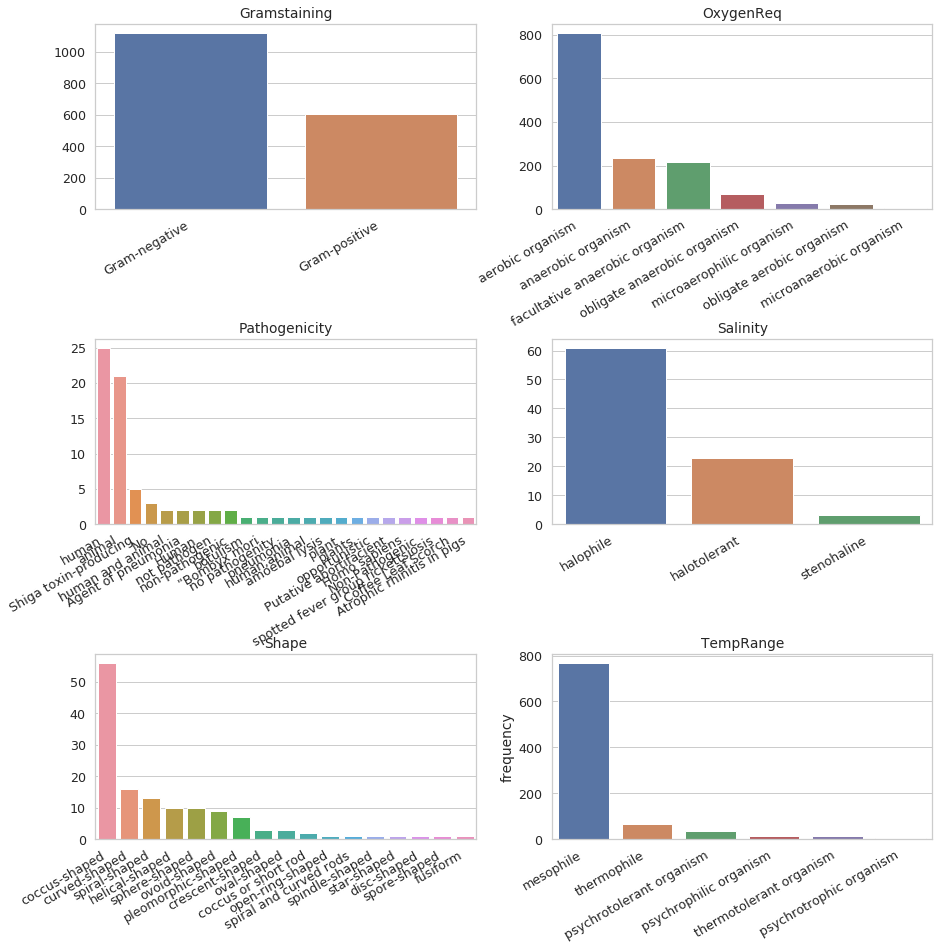

In [13]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# f, ax = plt.subplots(3,2, figsize=(15, 15), sharey=False)
# sns.set(style="whitegrid", font_scale=1.15)
# f.subplots_adjust(hspace = 0.7)
# for i, counts in enumerate(count_dict):
#     data = count_dict[counts]
#     ax = plt.subplot(321 + i)
#     xlab = list(data.index.value_counts().keys())
#     ax = sns.barplot(x=data.index.value_counts().keys(), 
#                      y=data.index.value_counts().values)
#     ax.set(title=counts.split("_")[3][:-4])
#     ax.set_xticks(range(len(data.index.value_counts().keys(),)))
#     ax.set_xticklabels(xlab, rotation=30, ha="right") 
#     ax.set_xlabel("")
# ax.set_ylabel("frequency")
# plt.show()